## Urban Operations Research for Transportation Systems
### M.Sc. Transportation, Problem Set 2

In [1]:
# general purpose python libraries
import math
import numpy as np
import pandas as pd

# visualization purposes
import matplotlib.pyplot as plt

# solving optimization problems
import pyomo.environ as pyo
import pyomo.opt as pyopt

# fuzzy expert library to solve mandani fuzzy inference problems
from fuzzy_expert.variable import FuzzyVariable
from fuzzy_expert.rule import FuzzyRule
from fuzzy_expert.inference import DecompositionalInference
from fuzzy_expert.mf import MembershipFunction

# may required for solving bwm problems
from pyDecision.algorithm import bw_method
# to work with simplex algorithm- linear programming problems
from scipy.optimize import linprog


pd.options.mode.chained_assignment = None  # default='warn'

# Problem 1 

## Fetch the Datasets

fetching the rating data for all experts 

an excel file has been used for the data

we are using read_excel() function to fetch the data

we have 3 excel files to be fetched. 

In [2]:
address="Second Level Criteria.xlsx"
# we need to extract the ratings for all (5) experts
ratings = []
for i in range(0,5):
    sheetName = "Expert "+ str(i+1)
    df = pd.read_excel(address, sheet_name = sheetName, skiprows = 2, nrows= 6, header=None)
    df.columns=["Criteria","Best","Worst"]
    ratings.append(df)
    #print(ratings[i])

address="Third Level C2.xlsx"
# we need to extract the ratings for all (5) experts
ratings_C2 = []
for i in range(0,5):
    sheetName = "Expert "+ str(i+1)
    df = pd.read_excel(address, sheet_name = sheetName, skiprows = 2, nrows= 6, header=None)
    df.columns=["Criteria","Best","Worst"]
    ratings_C2.append(df)
    #print(ratings[i])
    
address= "Third Level C4.xlsx"

# we need to extract the ratings for all (5) experts
ratings_C4 = []
for i in range(0,5):
    sheetName = "Expert "+ str(i+1)
    df = pd.read_excel(address, sheet_name = sheetName, skiprows = 2, nrows= 6, header=None)
    df.columns=["Criteria","Best","Worst"]
    ratings_C4.append(df)
    #print(ratings[i])

The symbols such as EI, WI, etc. are replaced by the values below

## Model 

After having the numerical comparision values of the criteria, we need to find the proper weights
by using the mathematical model and solver for the "best worst method".

In [3]:
#=============================================================================
# Model
#=============================================================================
def apply_model(dff):
    df = dff.copy()
    # the reason to have such a condition check is that
    # there is no EI value in the second level ratings for Expert 4
    if "EI" in df["Best"].tolist():
        Best = df["Criteria"][df[df["Best"] == "EI"].index.tolist()[0]]
    else:
        Best = df["Criteria"][df[df["Best"] == "WI"].index.tolist()[0]]  
    Worst= df["Criteria"][df[df["Worst"] == "EI"].index.tolist()[0]]
    df.columns=["Criteria",Best,Worst]
    Cnum=df.shape[0]
    
    df.set_index(df["Criteria"],inplace=True)
    # Fuzzification
    Fuzzy={ "EI":[1, 1, 1],
        "WI":[2/3, 1, 3/2],
        "FI":[3/2, 2, 5/2],
        "VI":[5/2, 3, 7/2],
        "AI":[7/2, 4, 9/2]}
    for i in [Best,Worst]:
        for j in range(df.shape[0]):
            df[i][j] = Fuzzy[df[i][j]]
    
    weight = dict()
    
    Model = pyo.ConcreteModel()

    # Set
    Model.Criteria=pyo.Set(initialize=df["Criteria"])

    # Set and variable
    Model.L=pyo.Var(Model.Criteria, within=pyo.PositiveReals)
    Model.M=pyo.Var(Model.Criteria, within=pyo.PositiveReals)
    Model.U=pyo.Var(Model.Criteria, within=pyo.PositiveReals)
    Model.ksi=pyo.Var(within=pyo.NonNegativeReals)

    def obj1(model):
        return Model.ksi
    Model.obj1=pyo.Objective(expr=obj1 ,sense=pyo.minimize)
    # Model.obj1.pprint()

    L=[Model.L, Model.M, Model.U]
    Lp=L.copy(); Lp.reverse()

    def Co1(Model, i, j):
        return (j[Best]-df[Best][i][L.index(j)]*Lp[L.index(j)][i]<= Model.ksi*Lp[L.index(j)][i])
    Model.Co1 = pyo.Constraint(Model.Criteria, L, rule=Co1)
    # Model.Co1.pprint()

    def Co2(Model, i, j):
        return (j[Best]-df[Best][i][L.index(j)]*Lp[L.index(j)][i]>= -Model.ksi*Lp[L.index(j)][i])
    Model.Co2 = pyo.Constraint(Model.Criteria, L, rule=Co2)
    # Model.Co2.pprint()

    def Co3(Model, i, j):
        return (j[i]-df[Worst][i][L.index(j)]*Lp[L.index(j)][Worst]<= Model.ksi*Lp[L.index(j)][Worst])
    Model.Co3 = pyo.Constraint(Model.Criteria, L, rule=Co3)
    # Model.Co3.pprint()

    def Co4(Model, i,j):
        return (j[i]-df[Worst][i][L.index(j)]*Lp[L.index(j)][Worst]>= -Model.ksi*Lp[L.index(j)][Worst])
    Model.Co4 = pyo.Constraint(Model.Criteria, L, rule=Co4)
    # Model.Co4.pprint()

    def Co5(Model):
        return (sum(j[i] if L.index(j)!=1 else 4*j[i] for i in Model.Criteria for j in L)/6==1)
    Model.Co5 = pyo.Constraint(rule=Co5)
    # Model.Co5.pprint()

    def Co6(Model,i):
        return (Model.L[i]<=Model.M[i])
    Model.Co6 = pyo.Constraint(Model.Criteria,rule=Co6)
    # Model.Co6.pprint()

    def Co7(Model,i):
        return (Model.M[i]<=Model.U[i])
    Model.Co7 = pyo.Constraint(Model.Criteria,rule=Co7)
    
    return Model, L


As I mentioned earlier we have three excel files to be fetched. One is for to find weight values for the second level criteria. The other two are for the third level criteria also known as sub-criteria. Below we calculate the weight values for these 3 criteria. 

## Calculating Weights and Consistency Ratios 

By using the fetched data and the model constructed for the BWM, we can finally end up with the weights for criteria and consistency ratio for the experts.

In [4]:
inconsistency_index = {2:0.44, 3:1.00, 4:1.63, 5:2.30, 6:3.00, 7:3.73, 8:4.47, 9:5.23}

weights_second_level = []
for i in range(len(ratings)):
    Model, L = apply_model(ratings[i])
    # the reason to add such a if condition is that solver is working properly
    if i==0:
        results = pyopt.SolverFactory("ipopt").solve(Model, tee=True) 
    else:
        results = pyopt.SolverFactory("ipopt").solve(Model, tee=False)
        
    print("Second Level-Expert ", i+1," ksi= ",Model.ksi())
    print("consistency_ratio= ", Model.ksi()/inconsistency_index[8])
    weight = dict()
    for i in Model.Criteria:
        a = []
        for j in L:
            a.append(j[i].value)
        weight.update({i: a})
    weights_second_level.append(weight)
    
weights_third_level_C2 = []
for i in range(len(ratings_C2)):
    Model, L = apply_model(ratings_C2[i])
    results = pyopt.SolverFactory("ipopt").solve(Model, tee=False) # doctest: +SKIP
    print("Third Level C2-Expert ", i+1," ksi= ",Model.ksi())
    print("consistency_ratio= ", Model.ksi()/inconsistency_index[8])
    weight = dict()
    for i in Model.Criteria:
        a = []
        for j in L:
            a.append(j[i].value)
        weight.update({i: a})
    weights_third_level_C2.append(weight)   

weights_third_level_C4 = []
for i in range(len(ratings_C4)):
    Model, L = apply_model(ratings_C4[i])
    results = pyopt.SolverFactory("ipopt").solve(Model, tee=False) # doctest: +SKIP
    print("Third Level C4-Expert ", i+1," ksi= ",Model.ksi())
    print("consistency_ratio= ", Model.ksi()/inconsistency_index[8])
    weight = dict()
    for i in Model.Criteria:
        a = []
        for j in L:
            a.append(j[i].value)
        weight.update({i: a})
    weights_third_level_C4.append(weight)
     
"""
print("ksi= ",Model.ksi())
Model.pprint()
Model.display()
        
"""

Ipopt 3.14.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:      156
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:       13
                     variables with only lower bounds:       13
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number

'\nprint("ksi= ",Model.ksi())\nModel.pprint()\nModel.display()\n        \n'

## Final Weights

We need to find the final weights by averaging center weight values considering all expert opinions. Here there is an additional important step regarding the consistenct ratios of the experts. I have calculated the consistenct ratios and assume that all the rating are applicable. Because of this reason, I have directly calculate the final weights by taking care of all experts.

In [5]:
averaged_weights_second_level = []
for j in range(len(weights_second_level[0])):
    sum = 0
    w = "C"+ str(j+1)
    w1 = w + "\xa0"
    for i in range(len(weights_second_level)):
        if i != 1:
            sum += weights_second_level[i][w1][1]
        else:
            sum += weights_second_level[i][w][1]
    averaged_weights_second_level.append(sum/len(weights_second_level))
print(averaged_weights_second_level)

[0.12951447996617393, 0.21521005295774379, 0.32800715988194257, 0.3246983550864698]


In [6]:
averaged_weights_third_level_C2 = []
for j in range(len(weights_third_level_C2[0])):
    sum = 0
    w = "C2-"+ str(j+1)
    for i in range(len(weights_third_level_C2)):
        sum += weights_third_level_C2[i][w][1]
    averaged_weights_third_level_C2.append(sum/len(weights_third_level_C2))
print(averaged_weights_third_level_C2)


[0.24518597357675093, 0.32867569151374676, 0.4254448545249292]


In [7]:
averaged_weights_third_level_C4 = []
for j in range(len(weights_third_level_C4[0])):
    sum = 0
    w = "C4-"+ str(j+1)
    for i in range(len(weights_third_level_C4)):
        sum += weights_third_level_C4[i][w][1]
    averaged_weights_third_level_C4.append(sum/len(weights_third_level_C4))
print(averaged_weights_third_level_C4)

[0.3493015712773431, 0.24091852979784587, 0.2608982699672259, 0.1435581488983717]


In [8]:
## final weights 
C1 = averaged_weights_second_level[0]
C2_1 = averaged_weights_second_level[1]*averaged_weights_third_level_C2[0]
C2_2 = averaged_weights_second_level[1]*averaged_weights_third_level_C2[1]
C2_3 = averaged_weights_second_level[1]*averaged_weights_third_level_C2[2]
C3 = averaged_weights_second_level[2]
C4_1 = averaged_weights_second_level[3]*averaged_weights_third_level_C4[0]
C4_2 = averaged_weights_second_level[3]*averaged_weights_third_level_C4[1]
C4_3 = averaged_weights_second_level[3]*averaged_weights_third_level_C4[2]
C4_4 = averaged_weights_second_level[3]*averaged_weights_third_level_C4[3]
print("C1: ", C1)
print("C2_1: ", C2_1)
print("C2_2: ", C2_2)
print("C2_3: ", C2_3)
print("C3: ", C3)
print("C4_1: ", C4_1)
print("C4_2: ", C4_2)
print("C4_3: ", C4_3)
print("C4_4: ", C4_4)

C1:  0.12951447996617393
C2_1:  0.05276648635794853
C2_2:  0.0707343129765965
C2_3:  0.09156000967290961
C3:  0.32800715988194257
C4_1:  0.11341764562287261
C4_2:  0.07822585033521122
C4_3:  0.08471323910326399
C4_4:  0.046613094806559806


# Problem 2 (A)

The most commonly used fuzzy inference technique is Mandani method. The Mandani-style fuzzy inference process is performed in four steps.

- fuzzification of the input variables

- rule evaluation (inference)

- aggregation of the rule outputs (composition)

- defuzzification

### Variable specification & fuzzification of the input variables

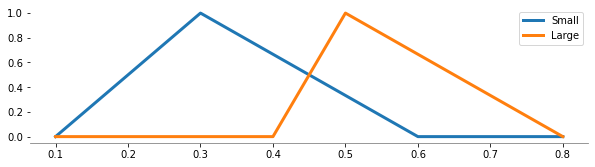

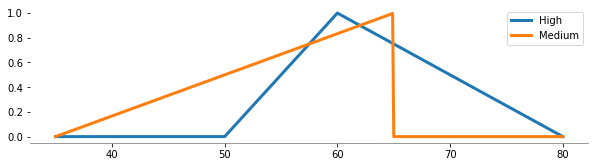

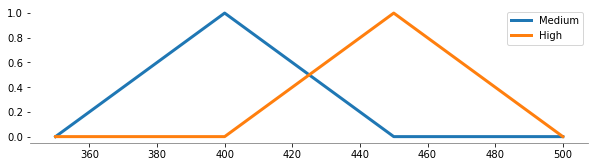

In [9]:
variables = {
    "mass": FuzzyVariable(
        universe_range=(0.1, 0.8),
        terms={
            "Small": [(0.1, 0), (0.3, 1), (0.6, 0)],
            "Large": [(0.4, 0), (0.5, 1), (0.8, 0)],
        },
    ),
    "velocity": FuzzyVariable(
        universe_range=(35, 80),
        terms={
            "High": [(50, 0), (60, 1), (80, 0)],
            "Medium": [(35, 0), (65, 1), (65, 0)],
        },
    ),
    "energy": FuzzyVariable(
        universe_range=(350, 500),
        terms={
            "Medium": [(350, 0), (400, 1), (450, 0)],
            "High": [(400, 0), (450, 1), (500, 0)],
        },
    ),
}

plt.figure(figsize=(10, 2.5))
variables["mass"].plot()
plt.figure(figsize=(10, 2.5))
variables["velocity"].plot()
plt.figure(figsize=(10, 2.5))
variables["energy"].plot()


One can see the membership functions above for inputs which are mass, velocity and output which is energy

### Rule Specification

In [10]:
rules = [
    FuzzyRule(
        premise=[
            ("mass", "Small"),
            ("AND", "velocity", "High"),
        ],
        consequence=[("energy", "Medium")],
    ),
    FuzzyRule(
        premise=[
            ("mass", "Large"),
            ("OR", "velocity", "Medium"),
        ],
        consequence=[("energy", "High")],
    )
]

print(rules[0])
print()
print(rules[1])

IF  mass IS Small
    AND velocity IS High
THEN
    energy IS Medium
CF = 1.00
Threshold-CF = 0.00


IF  mass IS Large
    OR velocity IS Medium
THEN
    energy IS High
CF = 1.00
Threshold-CF = 0.00



### Aggregation of the rule outputs & Defuzzification

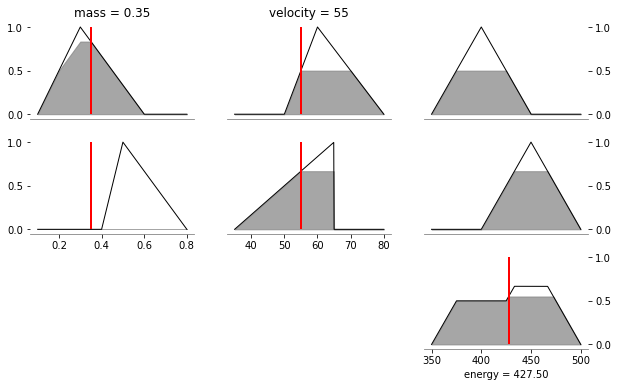

In [11]:
model = DecompositionalInference(
    and_operator="min",
    or_operator="max",
    implication_operator="Rc",
    composition_operator="max-min",
    production_link="max",
    defuzzification_operator="cog",
)

model(
    variables=variables,
    rules=rules,
    mass=0.35,
    velocity=55,
)

plt.figure(figsize=(10, 6))
model.plot(
    variables=variables,
    rules=rules,
    mass=0.35,
    velocity=55,
)

# Problem 2 (B)

In this problem type we only have one input variable and one output variable

### Variable specification & fuzzification of the input variables

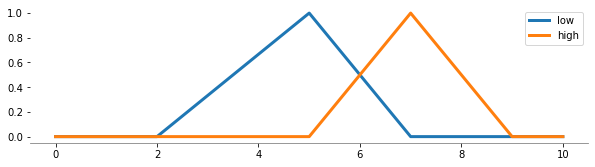

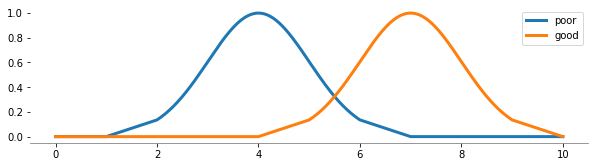

In [12]:

mf = MembershipFunction(n_points=100)
mf_2 = MembershipFunction(n_points=100)

variables_2 = {
    "a_input": FuzzyVariable(
        universe_range=(0, 10),
        terms={
            "low": [ (2, 0), (5, 1), (7, 0)],
            "high": [(5, 0), (7, 1), (9, 0)],
        },
    ),
    "b_output": FuzzyVariable(
        universe_range=(0, 10),
        terms={
            "poor": mf(('gaussmf', 4, 1)),
            "good": mf_2(('gaussmf', 7, 1)),
        },
    ),
}

plt.figure(figsize=(10, 2.5))
variables_2["a_input"].plot()
plt.figure(figsize=(10, 2.5))
variables_2["b_output"].plot()

To visualize a gaussian membership function, we need some sample from this distribution. In this case, we used 100 points to visualize the functions. One can see the results above.

### Rule Specification

In [13]:
rules = [
    FuzzyRule(
        premise=[
            ("a_input", "low"),
        ],
        consequence=[("b_output", "poor")],
    ),
    FuzzyRule(
        premise=[
            ("a_input", "high"),
        ],
        consequence=[("b_output", "good")],
    )
]

print(rules[0])
print()
print(rules[1])

IF  a_input IS low
THEN
    b_output IS poor
CF = 1.00
Threshold-CF = 0.00


IF  a_input IS high
THEN
    b_output IS good
CF = 1.00
Threshold-CF = 0.00



### Aggregation of the rule outputs & Defuzzification

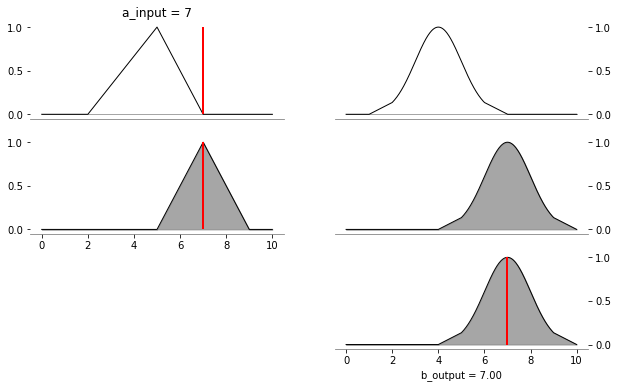

In [14]:
model_2 = DecompositionalInference(
    and_operator="min",
    or_operator="max",
    implication_operator="Rc",
    composition_operator="max-min",
    production_link="max",
    defuzzification_operator="cog",
)

#mf_3 = MembershipFunction(n_points=10)

plt.figure(figsize=(10, 6))
model_2.plot(
    variables=variables_2,
    rules=rules,
    #a_input = [(6, 0), (7, 0.3), (8, 0.5), (9, 0.7), (10, 0.9)],
    #a_input = mf_3(('gaussmf', 4, 1)),
    #a_input = [(5, 0), (6, 0.2), (7, 0)],
    a_input = 7,
)

# Problem 3

In order to solve this problem, we need to draw sample from log normal distributions: Below you can see the
procedure for this aim.

In [15]:
t_1 = np.random.lognormal(2.8, 0.2, 100)
t_2 = np.random.lognormal(1.5, 0.06, 100)

In the contraints part of the mathematical model, the 4th and 5th constraints are equality constraints
and the decision variables x_4 and x_5 are not related with the other decision variables which are x_1, x_2, and x_3. We can change the x_4 and x_5 values in the objective function by using the equalities in the 4th and 5th constraints. After that we can remove these constraints from the mathematical model since there is no relation with between the x_4, x_5 and x_1, x_2, and x_3.

The proposed mathematical model would be like:

min  4x_1 - 3x_2 + x_3 + 9(t_1 - 2x_1) - 2.25(2.5t_2 + 3x_1) + 2t_2

s.t. x_1 + x_3 >= 12

     x_2 + 1.2x_3 <= 22
     
     x_1 + x_2  <= 10
     
     x_1 + x_2 + x_3 <= 14
     
     defined sets for the decision variables would be the same with the original formulation


In [16]:
x_1_set = [2.5, 6, 10, 12, 14, 15]
x_2_set = [-2.5, -5.2, -2, 5.5, 10]
x_3_set = [0, 1]

In [18]:
def obj_func(x_1, x_2, x_3, t_1, t_2):
    return 4*x_1 - 3*x_2 + x_3 + 9*(t_1 - 2*x_1) - 2.25*(2.5*t_2 + 3*x_1) + 2*t_2

In [19]:
min = 99999999
optimal_dec_variables = []
for x_1 in x_1_set:
    for x_2 in x_2_set:
        for x_3 in x_3_set:
            if x_1 + x_3 >= 12:
                if x_2 + 1.2*x_3 <= 22:
                    if x_1 + x_2 <= 10:
                        if x_1 + x_2 + x_3 <= 14:
                            #print([x_1, x_2, x_3])
                            results = [obj_func(x_1, x_2, x_3, tt_1, tt_2) for tt_1 in t_1 for tt_2 in t_2]
                            if np.sum(results)/len(results) < min:
                                min = np.sum(results)/len(results)
                                optimal_dec_variables = [x_1, x_2, x_3]
                            
                                
print("the objective value of the mathematical model is ", min)
print("the optimal values of the decision variables are ", optimal_dec_variables)

the objective value of the mathematical model is  -166.5085942052793
the optimal values of the decision variables are  [15, -5.2, 0]


# Problem 4

In this problem, objective function and all the constraints are fuzzy. By using the Werner's approach, we need to solve four lp problem in total.

1) max z_0 = 25x+20y subject to 20x+12y <= 1800, 1/15x+1/15y <= 8, x>=0, y>=0

2) max z_1 = 25x+20y subject to 20x+12y <= 1900, 1/15x+1/15y <= 28, x>=0, y>=0

3) max a subject to 25x+20y>=z_1-(z_1-z_0)(1-a), 20x+12y<=1800+100(1-a), 1/15x+1/15y<=8+20(1-a), x>=0, y>=0, a>=0

4) max 25x+20y subject to 20x+12y<=1800+100(1-a), 1/15x+1/15y<=8+20(1-a), x>=0, y>=0 

### 1) LP(b)

In [20]:
obj = [-25,-20] #These are coefficients of our objective function. We just needed to multiply with -1 for maximization
lhs = [[20,12],[0.0666667, 0.0666667]] #LHS Inequalities. here 0.0666667 equals 1/15. check the question
rhs = [1800, 8]
bnd = [(0,float('inf')),(0,float('inf'))] #This is boundary of our decision variables used because positive
 

LP_b = linprog(c = obj,
                       A_ub = lhs,
                       b_ub = rhs,
                       bounds = bnd,
                       method = 'highs')
print("the optimal z_0 value is ",(LP_b.fun)*(-1))

the optimal z_0 value is  2624.9992500003755


### 2) LP(b+p)

In [21]:
obj = [-25,-20] #These are coefficients of our objective function. We just multiplied with -1 for maximization
lhs = [[20,12],[0.0666667, 0.0666667]] #LHS Inequalities. here 0.0666667 equals 1/15. check the question
rhs = [1900, 28]
bnd = [(0,float('inf')),(0,float('inf'))] #This is boundary of our decision variables used because positive
 

LP_bp = linprog(c = obj,
                A_ub = lhs,
                       b_ub = rhs,
                       bounds = bnd,
                       method = 'highs')
print("the optimal z_1 value is ",(LP_bp.fun)*(-1))
print("z_1 - z_0 is ",(LP_bp.fun)*(-1)-(LP_b.fun)*(-1))


the optimal z_1 value is  3166.666666666667
z_1 - z_0 is  541.6674166662915


### 3) max LP alpha

In [22]:
obj = [0,0,-1]  # respectively for x,y, and a
lhs = [[-25,-20,541.667417],[20,12,100],[0.0666667, 0.0666667,20]] #LHS Inequalities. here 0.0666667 equals 1/15. check the question
rhs = [-2624.999925, 1900, 28]
bnd = [(0,float('inf')),(0,float('inf')),(0,float('inf'))] #This is boundary of our decision variables used because positive

# in this problem, I have played with the first constraint some in order to have an appropriate format for the 
# function below (linprog)

LP_alpha = linprog(c = obj,
            A_ub = lhs,
            b_ub = rhs,
            bounds = bnd,
            method = 'highs')
print("the optimal alpha value is ",(LP_alpha.fun)*(-1))
print("(1-alpha) value is ",1-(LP_alpha.fun)*(-1))

the optimal alpha value is  0.7647051781875963
(1-alpha) value is  0.2352948218124037


### 4) Crisp Parametric LP

In [23]:
obj = [-25,-20] #These are coefficients of our objective function. We just needed to multiply with -1 for maximization
lhs = [[20,12],[0.0666667, 0.0666667]] #LHS Inequalities. here 0.0666667 equals 1/15. check the question
rhs = [1800+(1-(LP_alpha.fun)*(-1))*100, 8+(1-(LP_alpha.fun)*(-1))*20]
bnd = [(0,float('inf')),(0,float('inf'))] #This is boundary of our decision variables used because positive
 

LP_crisp = linprog(c = obj,
            A_ub = lhs,
            b_ub = rhs,
            bounds = bnd,
            method = 'highs')

print("the optimal z_0 value is ",(LP_crisp.fun)*(-1))
print("the optimal x value is ",(LP_crisp.x[0]))
print("the optimal y value is ",(LP_crisp.x[1]))

the optimal z_0 value is  3039.2158036354
the optimal x value is  0.0
the optimal y value is  151.96079018177
